In [ ]:
import os
import json
import yaml
import numpy
import random
from tqdm import tqdm
from collections import defaultdict

In [2]:
oapi_dir = "./openapi-directory-main/APIs/"

In [3]:
walked = os.walk(oapi_dir)
files = []
for i in list(walked):
    for j in i[2]:
        files.append(os.path.join(i[0],j))

In [4]:
import urllib.parse

def convert_to_json(oapi):
    # 每个操作将产生一个item
    ret = []
    # api版本规范解析
    version = 2 if 'openapi' in oapi else 3
    toget = 'paths' if 'paths' in oapi else 'webhooks'
    # api文档层面
    for path, schema in oapi[toget].items():
        if (not path) or (type(schema)!=dict):
            continue
        # 访问操作层面
        for verb_name, verb in schema.items():
            if type(verb) != dict:
                continue
            # 公共的参数
            desc = {}
            desc["verb"] = verb_name
            desc["url"] = path
            desc["apidesc"] = verb.get("description")
            desc["summary"] = verb.get("summary")
            if "responses" in verb and "description" in verb["responses"][list(verb["responses"])[0]]:
                desc["response_desc"] = verb["responses"][list(verb["responses"])[0]]["description"]
            else :
                desc["response_desc"] = None
            # 建立参数列表
            desc["params"] = []
            for param in verb.get("parameters",{}):
                if not param:
                    continue
                # 对引用中的参数进行解析
                if "$ref" in param:
                    refpath = param['$ref'].lstrip("#/").split("/")
                    if toget in refpath:
                        tmp = []
                        tmp.append(refpath[0])
                        tmp.append(urllib.parse.unquote("/".join(refpath[1:-3]).replace('~1','/')))
                        tmp += refpath[-3:-1]
                        tmp.append(eval(refpath[-1]))
                        refpath = tmp
                    param = oapi[refpath[0]]
                    for path in refpath[1:]:
                        param = param[path]
                # 各自的参数
                param_desc = {}
                param_desc["name"] = param.get("name")
                param_desc["type"] = param.get("type")
                param_desc["version"] = version
                param_desc["desc"] = param.get("description")
                param_desc["required"] = param.get("required")
                param_desc["in"] = param.get("in")
                param_desc["type"] = param.get("type")
                param_desc["format"] = param.get("format")
                param_desc["pattern"] = param.get("pattern")
                param_desc["example"] = param.get("example")
                # 版本差异带来的修正
                if 'schema' in param:
                    param_desc["type"] = param["schema"].get("type")
                    param_desc["format"] = param["schema"].get("format")
                    param_desc["pattern"] = param["schema"].get("pattern")
                    param_desc["example"] = param["schema"].get("example")
                desc["params"].append(param_desc)
            ret.append(desc)
    return ret


In [5]:
def read_data(file):
    data = None
    with open(file,"rb") as f:   
        try :
            text = f.read()
            # print(text[1084298-50:1084298+50])
            yamlfile = yaml.load(text,Loader=yaml.BaseLoader)
            data = convert_to_json(yamlfile)
        except Exception as err:
            print(file, err)
    return data

In [6]:
file = './openapi-directory-main/APIs/sendgrid.com\\1.0.0\\openapi.yaml'
with open(file,"rb") as f:   
    testdata = read_data(file)
testdata

In [ ]:
datas = []
for file in tqdm(files):
    data = read_data(file)
    if data:
        datas.append(data)

In [ ]:
from multiprocessing.dummy import Pool

if __name__=='__main__':
    datas, pool = [], Pool(8)
        
    datas = list(tqdm(pool.imap(read_data, files)))
    # pool.map_async(read_data, files, callback=update)
    pool.close()
    pool.join()

In [178]:
import json
with open("./dataset/oapi.json",'w') as f:
    json.dump(datas, f)

In [2]:
import json
with open("./dataset/oapi.json",'r') as f:
    datas = json.load(f)

In [4]:
print('共有', len(datas), '个api文档.')
datas[1]

共有 3796 个api文档.


[{'verb': 'get',
  'url': '/api/auth/introspect',
  'apidesc': None,
  'summary': 'Performs introspection of the provided Bearer JWT token',
  'response_desc': None,
  'params': []},
 {'verb': 'post',
  'url': '/api/v1/itemusages',
  'apidesc': 'This endpoint requires your JSON Web Token to have the *itemusages* feature.',
  'summary': 'Retrieves item usages',
  'response_desc': None,
  'params': []},
 {'verb': 'post',
  'url': '/api/v1/signinattempts',
  'apidesc': 'This endpoint requires your JSON Web Token to have the *signinattempts* feature.',
  'summary': 'Retrieves sign-in attempts',
  'response_desc': None,
  'params': []}]

In [4]:
operations = []
for api in tqdm(datas):
    for operation in api:
        operations.append(operation)
print('共有', len(operations), "个operations.")
operations[10]

100%|██████████| 3796/3796 [00:00<00:00, 223235.16it/s]

共有 122434 个operations.


{'verb': 'get',
 'url': '/vaults/{vaultUuid}',
 'apidesc': None,
 'summary': 'Get Vault details and metadata',
 'response_desc': 'OK',
 'params': [{'name': 'vaultUuid',
   'type': 'string',
   'version': 2,
   'desc': 'The UUID of the Vault to fetch Items from',
   'required': 'true',
   'in': 'path',
   'format': None,
   'pattern': '^[\\da-z]{26}$',
   'example': None}]}

In [5]:
import re
from w3lib.html import remove_tags
from w3lib.html import replace_entities
from w3lib.html import replace_escape_chars

> get_text_from_divs4 先用正则表达式，再使用w3lib。直接是html的使用only_html = True即可。

In [6]:
dr = re.compile(r'(<[^>]+>)', re.S)
removedr = re.compile(r'(<>)*(<[^>]+>)(<>)*', re.S)

def get_text_from_divs4(divs, only_html = False):
    if not divs:
        return None
  
    result = ""
    # 移除全部标签
    divs = remove_tags(divs)
    if not only_html:
        divs = dr.sub('',divs)  
    # 转换全部字符实体，将所有转义字符（\n,\r,\t）替换成空格：
    div_text = replace_escape_chars(replace_entities(divs), replace_by=" ")
    # 文本拼接成字符串，用空格间隔
    content = " ".join(div_text.split())
    result = result + content + " "
    
    if not only_html:
        #二次处理  之前有些 &lt 变成了 <  &gt 变成了 >
        result = removedr.sub('',result)
    return result


>数据集里面example、 response_desc 、desc、summary都有html标签

In [7]:
params = []
for operation in tqdm(operations):
    verb, response_desc, apidesc, summary = operation['verb'], operation['response_desc'], operation['apidesc'], operation['summary']
    for param in operation['params']:
        tmp = {}
        tmp['id'] = len(params)
        tmp['verb'] = verb
        tmp['oper_desc'] = get_text_from_divs4(apidesc)
        tmp['summary'] = get_text_from_divs4(summary)
        tmp['response_desc'] = get_text_from_divs4(response_desc)
        tmp['version'] = param['version']
        tmp['name'] = param['name']
        tmp['type'] = param['type']
        tmp['param_desc'] = get_text_from_divs4(param['desc'])
        tmp['required'] = param['required']
        tmp['in'] = param['in']
        tmp['format'] = param['format']
        tmp['pattern'] = param['pattern']
        # if type(param['example'])==datetime or type(param['example'])==date:
        tmp['example'] = get_text_from_divs4(str(param['example']))
        params.append(tmp)


100%|██████████| 122434/122434 [00:12<00:00, 10127.74it/s]


In [170]:
with open('./dataset/params.json','w') as f:
    json.dump(params,f)
print('共有', len(params), "个params.")
params[0]

共有 403106 个params.


{'id': 0,
 'verb': 'get',
 'oper_desc': None,
 'summary': 'Retrieve a list of API Requests that have been made. ',
 'response_desc': 'OK ',
 'version': 2,
 'name': 'limit',
 'type': 'integer',
 'param_desc': 'How many API Events should be retrieved in a single request. ',
 'required': None,
 'in': 'query',
 'format': None,
 'pattern': None,
 'example': '10 '}

In [1]:
import json
with open("./dataset/oapi.json",'r') as f:
    datas = json.load(f)
with open("./dataset/params.json",'r') as f:
    params = json.load(f)

In [3]:
len(params)

403106

In [6]:
params[0]

{'id': 0,
 'verb': 'get',
 'oper_desc': None,
 'summary': 'Retrieve a list of API Requests that have been made. ',
 'response_desc': 'OK ',
 'version': 2,
 'name': 'limit',
 'type': 'integer',
 'param_desc': 'How many API Events should be retrieved in a single request. ',
 'required': None,
 'in': 'query',
 'format': None,
 'pattern': None,
 'example': '10 '}

In [7]:
import pandas as pd
df = pd.read_json('./dataset/params.json')
((df.isnull().sum())/df.shape[0]).sort_values(ascending=False).map(lambda x:"{:.2%}".format(x))

pattern          96.03%
format           93.40%
summary          44.84%
oper_desc        31.85%
required         19.07%
param_desc        9.16%
response_desc     5.01%
type              2.86%
example           0.01%
id                0.00%
verb              0.00%
version           0.00%
name              0.00%
in                0.00%
dtype: object

In [13]:
params[14]

{'id': 14,
 'verb': 'put',
 'oper_desc': None,
 'summary': 'Update an Item ',
 'response_desc': 'OK ',
 'version': 2,
 'name': 'itemUuid',
 'type': 'string',
 'param_desc': 'The UUID of the Item to update ',
 'required': 'true',
 'in': 'path',
 'format': None,
 'pattern': '^[\\da-z]{26}$',
 'example': 'None '}

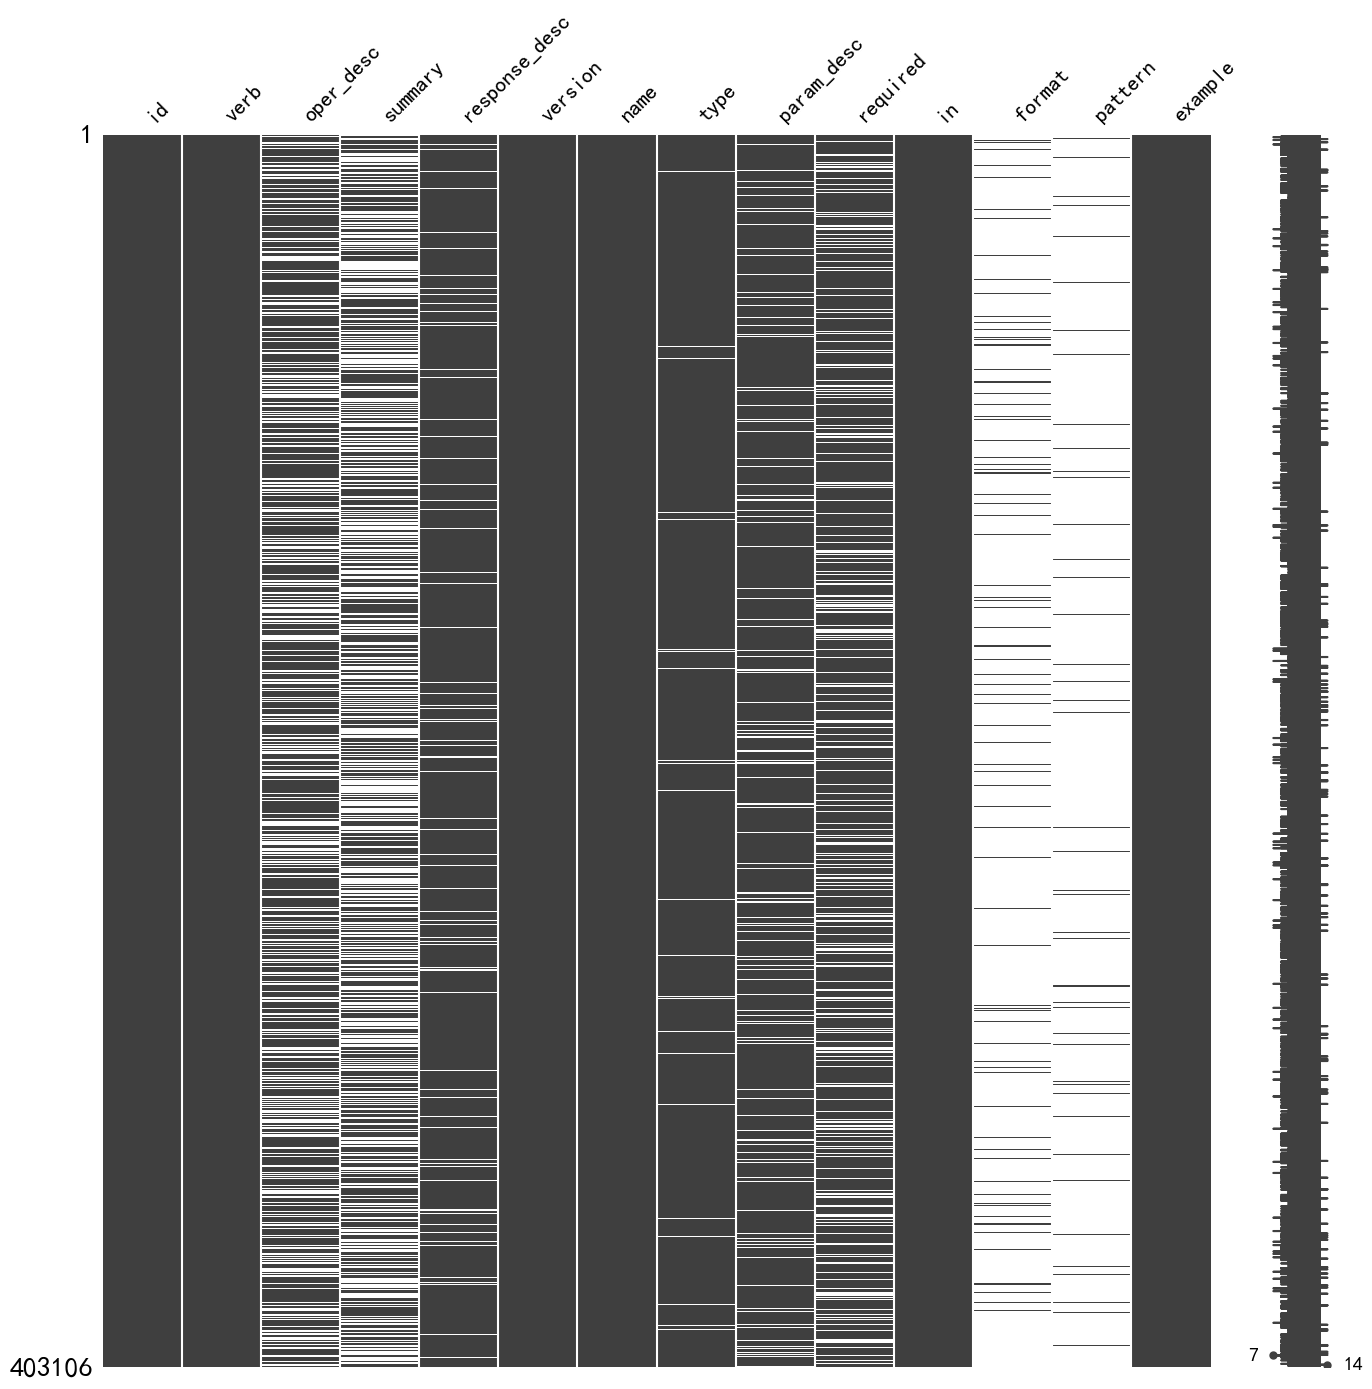

In [11]:
import numpy as np
import missingno as msno
from matplotlib import pyplot as plt
datefram = pd.read_json('./dataset/params.json')
msno.matrix(datefram.sample(datefram.shape[0]), figsize=(16, 16), width_ratios=(13, 1))
plt.rcParams['font.sans-serif']=['SimHei']   #这两行用来显示汉字
plt.rcParams['axes.unicode_minus'] = False
plt.show()


Counter({11: 202955, 10: 95497, 12: 76244, 13: 16883, 9: 10301, 8: 1013, 14: 141, 7: 72})


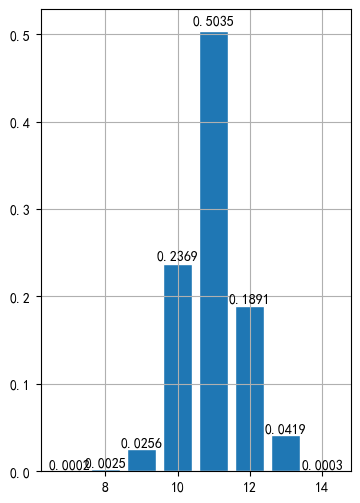

In [87]:
from collections import Counter
import seaborn as sns

import scipy.stats as stats
fig = plt.figure(figsize=(4,6)) 
rows_not_null = df.count(axis=1) 

rows_not_null = pd.Series(rows_not_null)
data =Counter(rows_not_null)
print(data)
# colors = ['slategray', 'lightskyblue', 'skyblue', 'steelblue', 'lightblue']
# plt.pie(data.values(),labels=data.keys(),colors=colors)
# plt.boxplot(rows_not_null)
# plt.show()
# sns.distplot(rows_not_null)
plt.grid()
n, bins, patches = plt.hist(rows_not_null,bins=np.arange(6.5,15.5),edgecolor ='w',density=True,rwidth=0.8)
for i in range(len(n)):
    plt.text(bins[i]+(bins[1]-bins[0])/2, n[i]*1.01, round(n[i],4), ha='center', va= 'bottom')
# rows_not_null.plot(kind = 'kde',label = '密度图') 

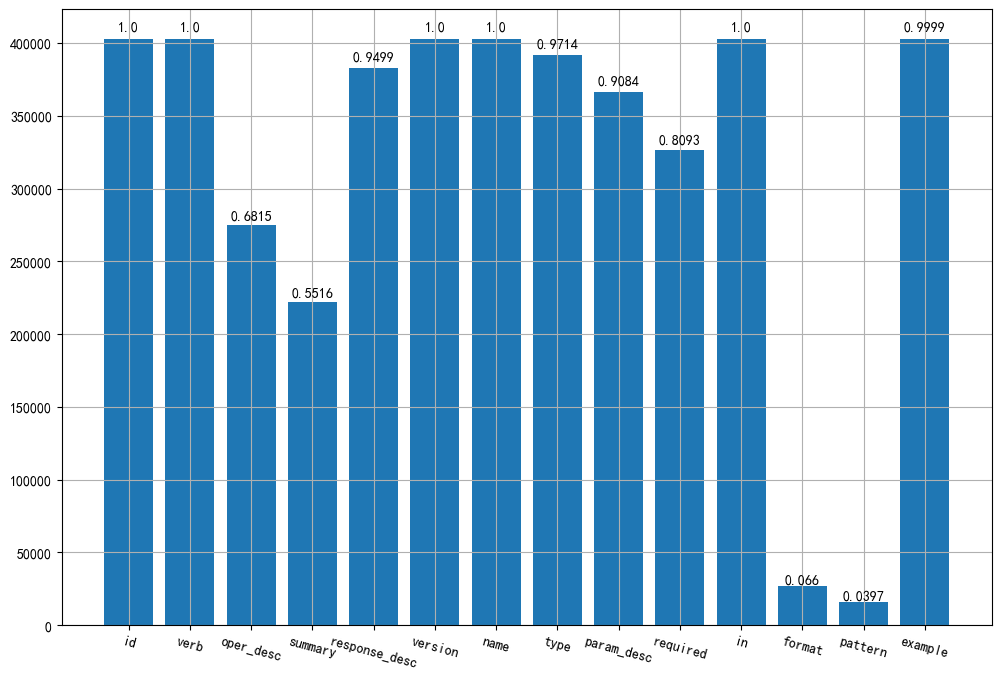

In [90]:
rows_not_null = df.count(axis=0) 
fig = plt.figure(figsize=(12,8)) 
plt.grid()
rows_not_null = pd.Series(rows_not_null)
plt.xticks(range(len(rows_not_null)), rows_not_null.index, rotation=-15) 
plt.bar(range(len(rows_not_null)), rows_not_null)  # 绘制y刻度标签
for i in range(len(rows_not_null)):
    plt.text(i, rows_not_null[i]*1.01, round(rows_not_null[i]/403106,4), ha='center', va= 'bottom')
# data =Counter(rows_not_null)
# print(data)
# # colors = ['slategray', 'lightskyblue', 'skyblue', 'steelblue', 'lightblue']
# # plt.pie(data.values(),labels=data.keys(),colors=colors)
# # plt.boxplot(rows_not_null)
# # plt.show()
# # sns.distplot(rows_not_null)
# plt.grid()
# n, bins, patches = plt.hist(rows_not_null,bins=np.arange(6.5,15.5),edgecolor ='w',density=True,rwidth=0.8)
# for i in range(len(n)):
#     plt.text(bins[i]+(bins[1]-bins[0])/2, n[i]*1.01, round(n[i],4), ha='center', va= 'bottom')

{'whiskers': [<matplotlib.lines.Line2D at 0x283c5561d90>,
 'caps': [<matplotlib.lines.Line2D at 0x28387884be0>,
 'boxes': [<matplotlib.patches.PathPatch at 0x283c724a280>,
 'medians': [<matplotlib.lines.Line2D at 0x283c720beb0>,
 'fliers': [<matplotlib.lines.Line2D at 0x283c720b5b0>,
 'means': [<matplotlib.lines.Line2D at 0x283c720b280>,
  <matplotlib.lines.Line2D at 0x283c6963e20>]}

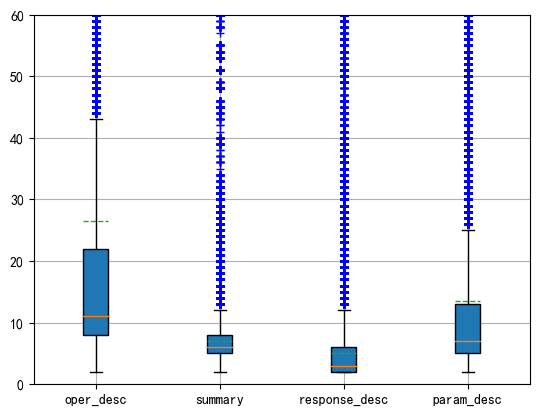

In [103]:
plt.grid()
lenth1,lenth2,lenth3,lenth4,lenth5 = [],[],[],[],[]
for i in datefram['oper_desc']:
    if i:
        lenth1.append(len(i.split(" ")))
for i in datefram['summary']:
    if i:
        lenth2.append(len(i.split(" ")))
for i in datefram['response_desc']:
    if i:
        lenth3.append(len(i.split(" ")))
for i in datefram['param_desc']:
    if i:
        lenth4.append(len(i.split(" ")))
plt.ylim((0,50))
plt.boxplot((lenth1,lenth2,lenth3,lenth4),labels=('oper_desc','summary','response_desc','param_desc'),vert=True, sym='+b',  showmeans=True,
                meanline=True, patch_artist=True, widths=0.2)

In [6]:
# import csv

# typedic = {}
# d_set = set()
# with open(r'./file.tsv', 'w', newline='', encoding='utf-8') as f:
#     tsv_w = csv.writer(f, delimiter='\t')
#     for param in params:
#         t, d = param['type'], param['param_desc']
#         if (t and d) and ("https://" not in d) and (d not in d_set):
#             d_set.add(d)
#             if t not in typedic:
#                 typedic[t] = len(typedic.keys())
#             tsv_w.writerow([d,typedic[t]])
# print(typedic)

In [2]:
str_inputs = []
for param in params:
    if param['summary'] and param['oper_desc']:
        param['desc'] = param['oper_desc'] if len(param['oper_desc'].split())>len(param['summary'].split()) else param['summary']
    else:
        param['desc']  = param['summary'] if param['summary'] else param['oper_desc']
    if param['desc'] and param['name'] and param['type'] and param['param_desc'] and (len(param['param_desc'])>=5) \
        and ("https://" not in param['param_desc']) and ("|" not in param['param_desc']) and ("|" not in param['desc']) and ("|" not in param['name']):
        str_input = {}
        str_input['src'] = "#".join(["desc:"+str(param['desc'].strip(' .?')),"name:"+str(param['name']),"type:"+str(param['type'])])
        str_input['trg'] = param['param_desc'].strip(" .?")
        # str_input = " | ".join(["desc : "+str(param['desc']).strip('.'),"name : "+str(param['name']),"type : "+str(param['type'])]) + "||"+param['param_desc']
        str_inputs.append(str_input)
print(len(str_inputs))

347775


In [3]:
import random
random.seed(20020104)
random.shuffle(str_inputs)

In [4]:
with open('./dataset/dataset_train.json','a',encoding='utf-8') as f:
    for str_input in str_inputs[:300000]:
        json.dump(str_input,f)
        f.write('\n')
        # f.write(str(str_input)+'\n')
        
        
with open('./dataset/dataset_valid.json','a',encoding='utf-8') as f:
    for str_input in str_inputs[300000:330000]:
        json.dump(str_input,f)
        f.write('\n')
        # f.write(str(str_input)+'\n')
        
        
with open('./dataset/dataset_test.json','a',encoding='utf-8') as f:
    for str_input in str_inputs[330000:]:
        json.dump(str_input,f)
        f.write('\n')
        # f.write(str(str_input)+'\n')

In [ ]:
with open('./dataset/dataset.json','r') as f:
    l = f.readlines()
print(len(l))

In [9]:
cntlist = []
for api in tqdm(datas):
    for operation in api:
        for param in operation['params']:
            notype = 0
            if not param['type']:
                notype =  1
            cntlist.append(notype)
            
print(sum(cntlist),len(cntlist),sum(cntlist)/len(cntlist))

100%|██████████| 3796/3796 [00:00<00:00, 55015.25it/s]

11534 403106 0.0286128214415067


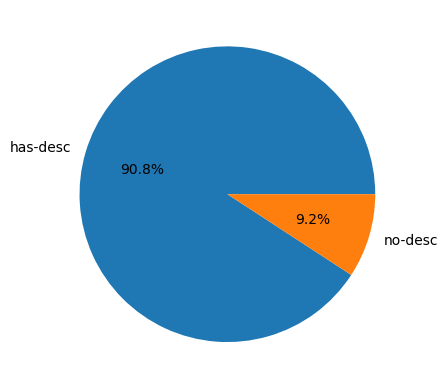

在403106个params中，有37074个params没有类型


In [21]:
import matplotlib.pyplot as plt

cnt, notype_params, hastype_params = 0, [], []
for param in params:
    if not param['param_desc'] or len(param['param_desc'])<=3 or str(param['param_desc']).strip(' .?').lower()==str(param['oper_desc']).strip(' .?').lower():
        notype_params.append(param)
        cnt+=1
    else:
        hastype_params.append(param)
        
plt.pie([len(params)-cnt, cnt],labels=['has-desc','no-desc'],autopct='%1.1f%%')
plt.show()
print("在{}个params中，有{}个params没有类型".format(len(params), cnt))

defaultdict(<class 'int'>, {'None': 2527, 'true': 27195, 'false': 7352})


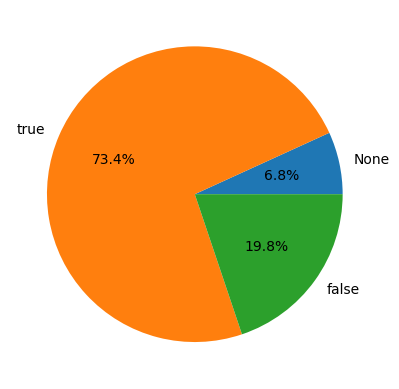

defaultdict(<class 'int'>, {'Have': 37074})


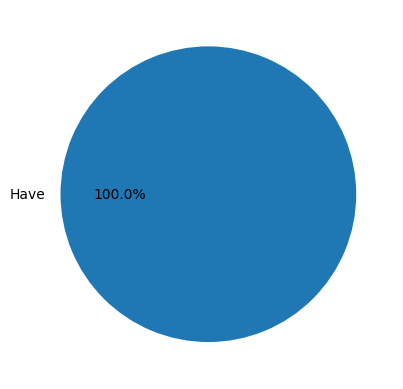

defaultdict(<class 'int'>, {'Have': 35793, 'None': 1281})


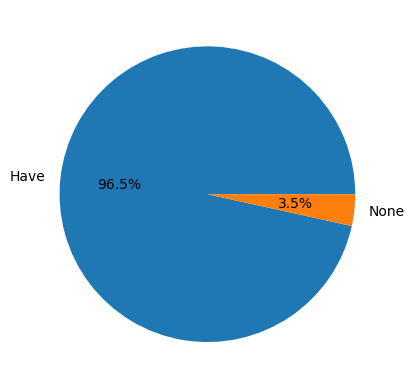

defaultdict(<class 'int'>, {'Have': 361966, 'None': 4066})


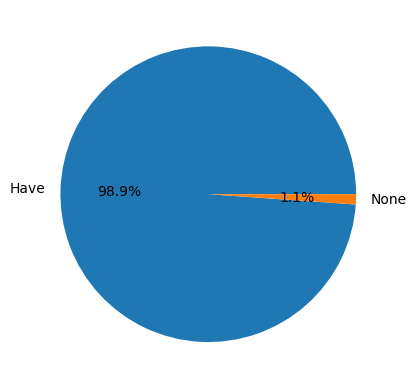

defaultdict(<class 'int'>, {'query': 16911, 'path': 13006, 'body': 1796, 'header': 5305, 'formData': 56})


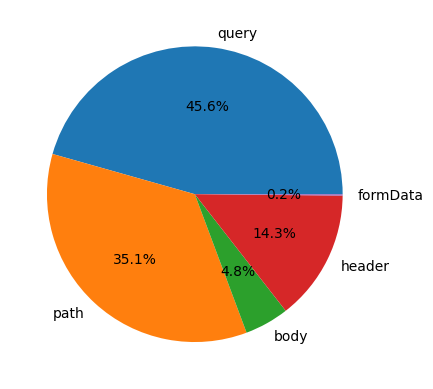

defaultdict(<class 'int'>, {'integer': 4987, 'string': 29025, 'object': 275, 'boolean': 564, 'array': 357, 'number': 132, 'None': 1732, 'file': 2})


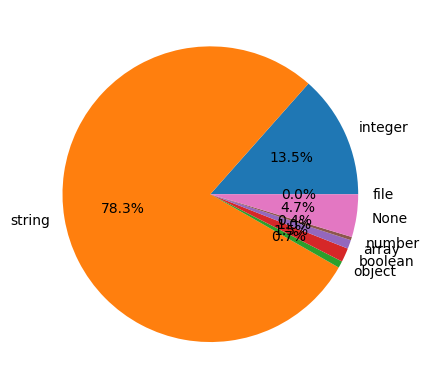

In [28]:
from collections import defaultdict 
def data_analysis(params, feat, classes = True):
    dct = defaultdict(int)

    for param in params:
        if classes:
            key = param[feat] if param[feat] else 'None'
        else:
            # key = "Have" if param[feat]  else 'None'
            key = "Have" if param[feat] not in ['body','parameters'] else 'None'
        dct[key] +=1
    
    print(dct)
    plt.pie([v for v in dct.values()],labels=dct.keys(),autopct='%1.1f%%')
    plt.tick_params(labelsize='large')
    plt.show()
    
data_analysis(notype_params, 'required', classes = True)
data_analysis(notype_params, 'example', classes = False)
data_analysis(notype_params, 'name', classes = False)
data_analysis(hastype_params, 'name', classes = False)
data_analysis(notype_params, 'in', classes = True)
data_analysis(notype_params, 'type', classes = True)


In [12]:
bodyparam = []
for param in params:
    if param['in']=='body':
        bodyparam.append(param)
        
# with open("./dataset/bodyparam.json",'w') as f:
    # json.dump(bodyparam, f)

defaultdict(<class 'int'>, {'object': 568, 'array': 112, 'None': 10010, 'string': 36, 'number': 2})


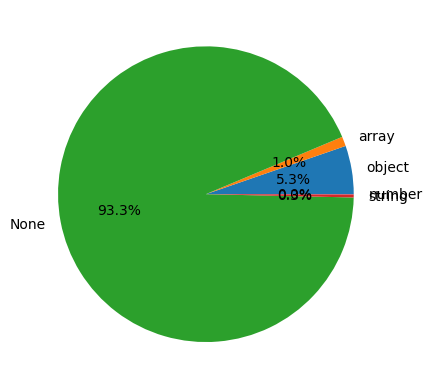

In [13]:
data_analysis(bodyparam, 'type', classes = True)


In [15]:
params[0]

{'id': 0,
 'verb': 'get',
 'oper_desc': None,
 'summary': 'Retrieve a list of API Requests that have been made. ',
 'response_desc': 'OK ',
 'version': 2,
 'name': 'limit',
 'type': 'integer',
 'param_desc': 'How many API Events should be retrieved in a single request. ',
 'required': None,
 'in': 'query',
 'format': None,
 'pattern': None,
 'example': '10 '}

In [53]:
save = []
for param in params:
    if param['oper_desc'] and param['param_desc']:
        save.append((param['oper_desc'], param['param_desc']))
    # if param['oper_desc'] and param['summary'] and param['param_desc']:
        # save.append((param['oper_desc']+param['summary'], param['param_desc']))

In [54]:
apidec,parmdec = [], []
random.shuffle(save)
for tup in save[250:300]:
    apidec.append(tup[0])
    parmdec.append(tup[1])

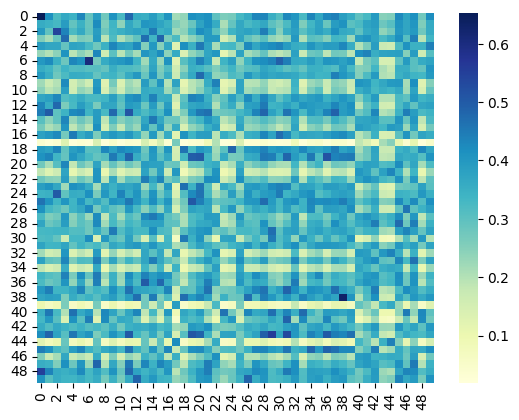

In [55]:
import Levenshtein

# random.shuffle(save)
def edit_distance(s1, s2):
    return Levenshtein.ratio(s1, s2)

heatmap = []
for a in apidec:
    heatline = []
    for p in parmdec:
        heatline.append(edit_distance(a,p))
    heatmap.append(heatline)
    
import numpy as np
import seaborn as sns

ax = sns.heatmap(heatmap, cmap="YlGnBu")

In [61]:
cals = 0
for tup in save:
    a = random.choice(save)
    b = random.choice(save)
    cals+=edit_distance(a[0],b[1])
    
print(cals/len(save))

0.3026264416316294


In [40]:
idx = 75
print(apidec[idx]+'\n',parmdec[idx])

Retrieves the payment link details using the payment link `id`. 
 Unique identifier of the payment link. 


In [ ]:
from IPython.display import clear_output
import random
random.shuffle(data)
for d in data:
    print(json.dumps(d,indent=2)) 
    if input()=="0":
        break
    clear_output(wait=True)